# Chapter 1
- Video lession: [video](https://www.youtube.com/watch?v=8SF_h3xF3cE), [notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data)
- Text lession: [book](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb)

Thoughts:
* Create image recognition for multiple animals (cat, dog, mouse, hamster) and see how it goes.

Much of what follows is based on the [notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) used for the chapter 1 youtube video.  Streamlined and modified for the things I want to play with.  And to update code to remote warnings sometimes...

In [3]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")


In [6]:
!pip install -Uqq fastai duckduckgo_search

In [10]:
from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

In [11]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

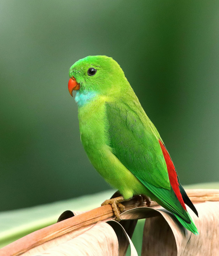

In [12]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


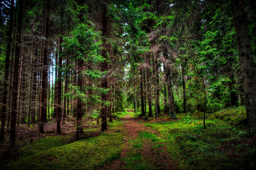

In [13]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [14]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

/opt/app-root/lib64/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


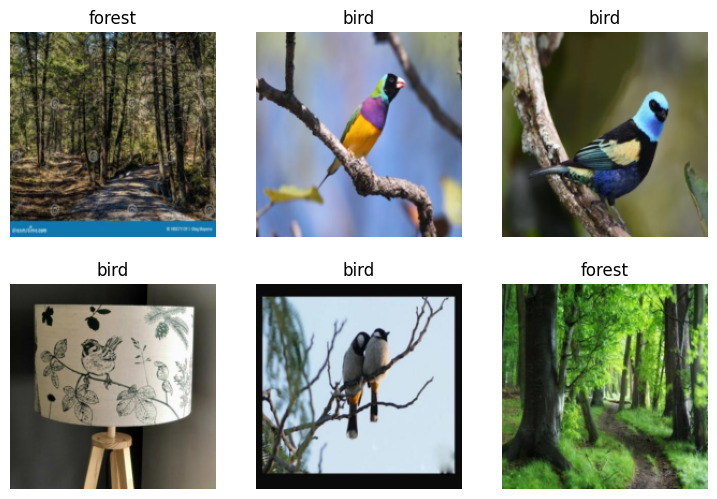

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /opt/app-root/src/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 231MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.842392,0.361447,0.125000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.142347,0.043848,0.000000,00:05
1,0.095491,0.017588,0.000000,00:06
2,0.065994,0.008848,0.000000,00:06


In [24]:
category,category_num,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {category} ({category_num}).")
print(f"Probability it's a {category}: {probs[category_num]:.4f}")

This is a: bird (0).
Probability it's a bird: 0.9997


In [25]:
category,category_num,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {category} ({category_num}).")
print(f"Probability it's a {category}: {probs[category_num]:.4f}")

This is a: forest (1).
Probability it's a forest: 1.0000
